In [280]:
# Trimmed mean

In [281]:
# libraries 

from getData import get_data, get_ohlcv
from technical_indicator import LR, MACD, RSI, BB, ATR, ADX, RENKO, anomaly, historical_volatility, get_support_resistance_levels, VWAP
from Returns import cummulative_returns, CAGR, volatility, SHARPE, SORTINO, MAXDROWDOWN, CALMAR
from signals import stratgey1_mean_reversion, label_sd_categories

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import copy

%load_ext autoreload
%autoreload 2
pd.set_option('mode.chained_assignment', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting Data

In [323]:
tickers = ['BEL.NS']
tickers

['BEL.NS']

In [331]:
# Store data in dictionary
ohlcv_dict = {}
for stock in tickers:
    ohlcv_dict[stock] = get_ohlcv(ticker=stock, period = '5y', interval='1d', multi_level_index=False)
    # ohlcv_dict[stock] = ohlcv_dict[stock].between_time('09:35', '16:00')

[*********************100%***********************]  1 of 1 completed


In [332]:
data = copy.deepcopy(ohlcv_dict)

# Calculation on Data

In [333]:
for stock_name in tickers:
    cummulative_returns(data[stock_name])
    ATR(data[stock_name])
    anomaly(data[stock_name])
    support, resistnace  = get_support_resistance_levels(data[stock_name])
    data[stock_name]['support'] = support
    data[stock_name]['resistance'] = resistnace
    historical_volatility(data[stock_name])
    historical_volatility(data[stock_name])
    RSI(data[stock_name])
    VWAP(data[stock_name])
    BB(data[stock_name])
    data[stock_name]['Close'] = round(data[stock_name]['Close'],2)
    data[stock_name]['Signal'] = data[stock_name].apply(stratgey1_mean_reversion, axis=1)
    data[stock_name]['m_half_50'] = data[stock_name]['Close'].ewm(halflife=50).mean()
    data[stock_name]['Distance_From_Mean'] = (data[stock_name]['Close'] - data[stock_name]['m_half_50'])
    label_sd_categories(data[stock_name])
    print('--')

--


In [334]:
# data

In [335]:
label_sd_categories(data[stock_name])['Label'].value_counts()

Label
AT MEAN       1044
ABOVE 1 SD      93
ABOVE 3 SD      48
BELOW 1 SD      27
ABOVE 2 SD      24
BELOW 2 SD       4
Name: count, dtype: int64

In [336]:
df = data[stock_name]
resistance = df.loc[df['resistance']>1]['resistance'].tail(3)
resistance.name = 'Close'
# resistance
resistance_levels = [
    {"date": date.strftime("%Y-%m-%d"), "Close": round(Close,2)}
    for date, Close in resistance.items()
]
# resistance_levels

support = df.loc[df['support']>1]['support'].tail(3)
support.name = 'Close'
# resistance
support_levels = [
    {"date": date.strftime("%Y-%m-%d"), "Close": round(Close,2)}
    for date, Close in support.items()
]
# support_levels

# Buy
buy = df.loc[df['Signal'] ==1]['Close'].tail(5)
buy.name = 'Close'

# Sell
sell = df.loc[df['Signal'] ==-1]['Close'].tail(5)
sell.name = 'Close'

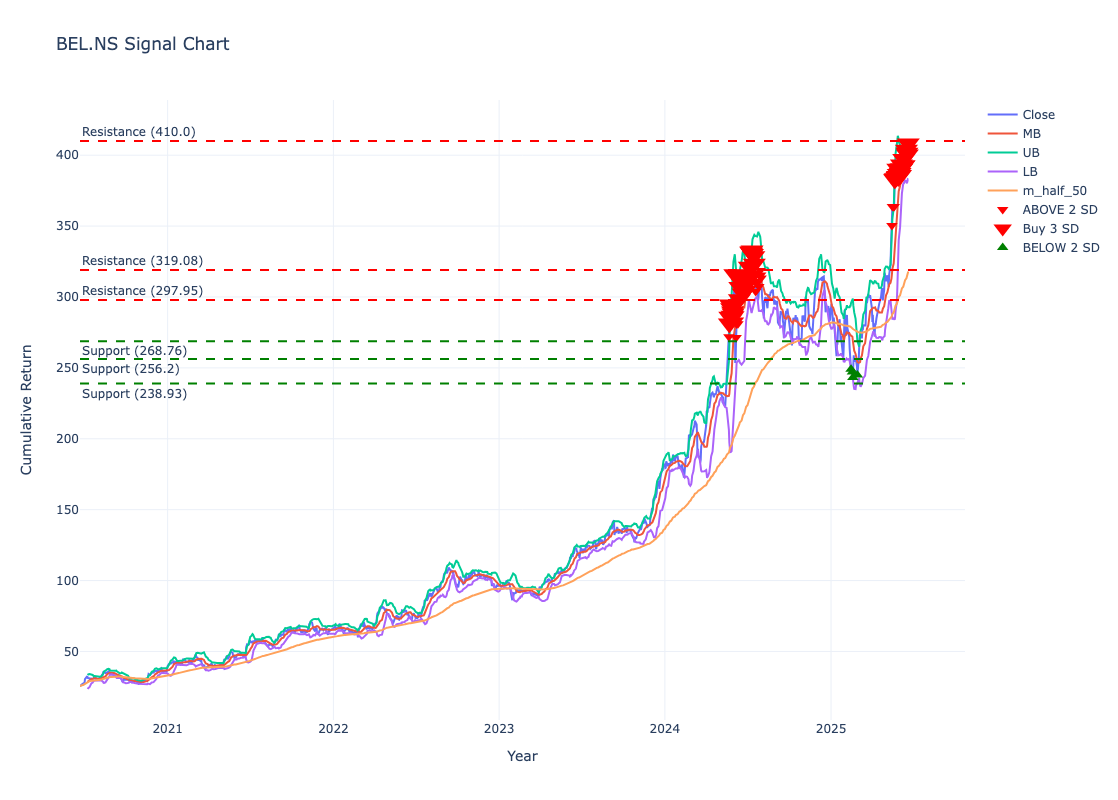

In [337]:
fig = go.Figure()
#Close
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['Close'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='Close'# Use the name for each line from the dictionary
    ))   
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['MB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='MB'# Use the name for each line from the dictionary
    ))

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['UB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='UB'# Use the name for each line from the dictionary
    ))
    
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['LB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='LB'# Use the name for each line from the dictionary
    )) 

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['m_half_50'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='m_half_50'# Use the name for each line from the dictionary
    )) 

for level in support_levels:
    fig.add_hline(
        y=level["Close"],
        line=dict(color="green", dash="dash"),
        annotation_text=f"Support ({level['Close']})",
        annotation_position="bottom left"
    )

# Add resistance lines
for level in resistance_levels:
    fig.add_hline(
        y=level["Close"],
        line=dict(color="red", dash="dash"),
        annotation_text=f"Resistance ({level['Close']})",
                annotation_position="top left"
    )

for key in data:
    fig.add_trace(go.Scatter(
        x=data[stock_name][data[stock_name]['Label'] == 'ABOVE 2 SD'].index,
        y=data[stock_name][data[stock_name]['Label'] == 'ABOVE 2 SD']['Close'],
        mode='markers',
        name='ABOVE 2 SD',
        marker=dict(color='red', size=10, symbol='triangle-down')
    ))
    
for key in data:
    fig.add_trace(go.Scatter(
        x=data[stock_name][data[stock_name]['Label'] == 'ABOVE 3 SD'].index,
        y=data[stock_name][data[stock_name]['Label'] == 'ABOVE 3 SD']['Close'],
        mode='markers',
        name='Buy 3 SD',
        marker=dict(color='red', size=20, symbol='triangle-down')
    ))

for key in data:
    fig.add_trace(go.Scatter(
        x=data[stock_name][data[stock_name]['Label'] == 'BELOW 2 SD'].index,
        y=data[stock_name][data[stock_name]['Label'] == 'BELOW 2 SD']['Close'],
        mode='markers',
        name='BELOW 2 SD',
        marker=dict(color='green', size=10, symbol='triangle-up')
    ))


for key in data:
    fig.add_trace(go.Scatter(
        x=data[stock_name][data[stock_name]['Label'] == 'BELOW 3 SD'].index,
        y=data[stock_name][data[stock_name]['Label'] == 'BELOW 3 SD']['Close'],
        mode='markers',
        name='BELOW 3 SD',
        marker=dict(color='green', size=20, symbol='triangle-up')
    ))


# #Buy
# fig.add_trace(go.Scatter(
#     x=buy.index,
#     y=buy.values,
#     mode='markers',
#     name='Buy Signal',
#     marker=dict(color='green', size=20, symbol='triangle-up')
#     ))


# #Sell
# fig.add_trace(go.Scatter(
#     x=sell.index,
#     y=sell.values,
#     mode='markers',
#     name='Sell Signal',
#     marker=dict(color='red', size=20, symbol='triangle-down')
#     ))

# Customize the layout
fig.update_layout(
    title=f"{stock_name} Signal Chart",
    xaxis_title="Year",
    yaxis_title="Cumulative Return",
    autosize=False,
    width=1100,
    height=800,
    template='plotly_white'
)

fig.show()

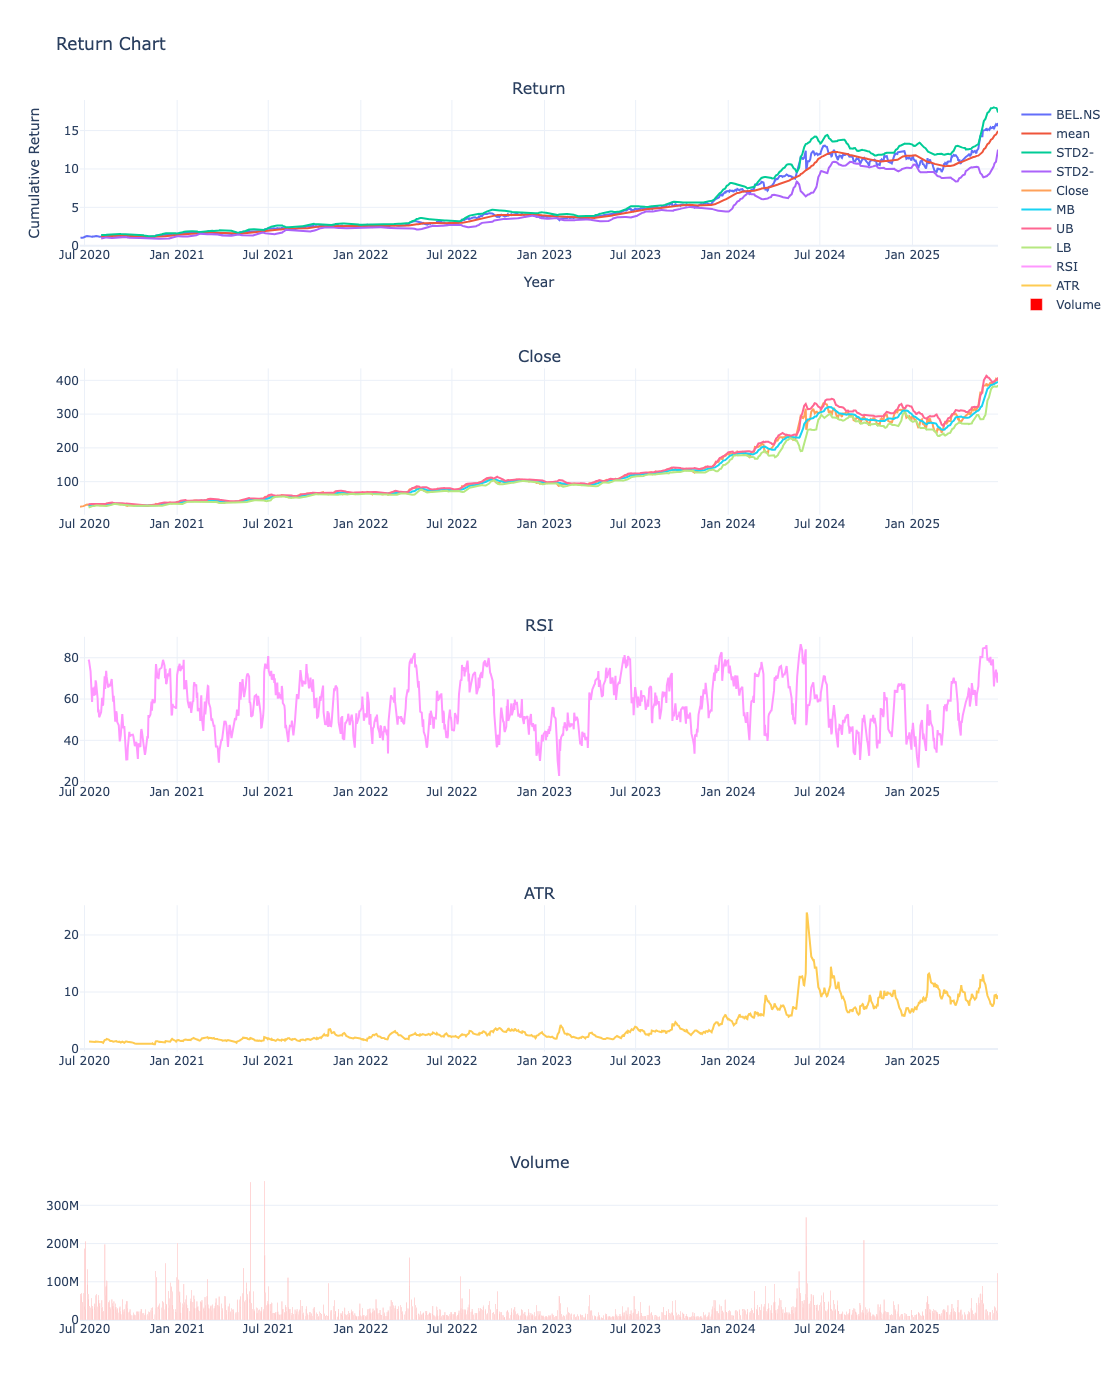

In [338]:
# Create a line chart
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# fig = go.Figure()

fig = make_subplots(
    rows=5, cols=1,
    subplot_titles=("Return", "Close", "RSI", "ATR", "Volume"))





# Add multiple lines (traces) to the figure
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['cum_rtn'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name=key# Use the name for each line from the dictionary
    ),  row=1, col=1,)

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['r_mean'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='mean'# Use the name for each line from the dictionary
    ),row=1, col=1,)

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['r_std2+'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='STD2-'# Use the name for each line from the dictionary
    ),row=1, col=1,)
    
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['r_std2-'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='STD2-'# Use the name for each line from the dictionary
    ),row=1, col=1,)   

#Close
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['Close'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='Close'# Use the name for each line from the dictionary
    ),row=2, col=1,)   
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['MB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='MB'# Use the name for each line from the dictionary
    ),row=2, col=1,)

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['UB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='UB'# Use the name for each line from the dictionary
    ),row=2, col=1,)
    
for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['LB'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='LB'# Use the name for each line from the dictionary
    ),row=2, col=1,) 

#RSI

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['RSI'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='RSI'# Use the name for each line from the dictionary
    ),row=3, col=1,)   


#ATR

for key in data:
    fig.add_trace(go.Scatter(
        x=data[key].index,
        y=data[key]['ATR'],
        mode='lines',  # Set the mode to 'lines' for a line chart
        name='ATR'# Use the name for each line from the dictionary
    ),row=4, col=1,)   

#Volume

for key in data:
    fig.add_trace(go.Bar(
        x=data[key].index,
        y=data[key]['Volume'],
        name='Volume',# Use the name for each line from the dictionary
        marker=dict(color='red')
    ),row=5, col=1,)   


# Customize the layout
fig.update_layout(
    title="Return Chart",
    xaxis_title="Year",
    yaxis_title="Cumulative Return",
    autosize=False,
    width=1100,
    height=1400,
    template='plotly_white'
)

# Show the plot
fig.show()